In [1]:
import random
import numpy as np
import pandas as pd
random.seed(3311791)
np.random.seed(3311791)
df = pd.read_csv('/kaggle/input/df-lemma-clean/df_lemma_dropped.csv').drop('H', axis=1)
df['Year'] = df['Year'].astype(int)

In [2]:
!pip install umap-learn hdbscan
!pip install BorutaShap
!pip install xlsxwriter
!pip install adjustText
from adjustText import adjust_text
from BorutaShap import BorutaShap
import umap
import hdbscan
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=a4a5c7ed2a1481169ba0fd9041645b87b6796ebd9d80d91b0dd8ba0f92f38c07
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.7 MB/s eta 0:00:

2024-05-17 14:01:04.213802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 14:01:04.213961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 14:01:04.466689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def umap_hdbscan_plot(df_plt):
    cmap = plt.cm.get_cmap('tab10', len(df_plt['cluster'].unique()))

    plt.figure(figsize=(10, 7))
    plt.scatter(df_plt['dim_1'], df_plt['dim_2'], color=cmap(df_plt['cluster']))

    # Get unique clusters
    unique_clusters = df_plt['cluster'].unique()
    random_clusters = random.sample(list(unique_clusters), 5)

    texts = []
    for cluster in random_clusters:
            cluster_points = df_plt[df_plt['cluster'] == cluster]
            sample_points = cluster_points.sample(min(3, len(cluster_points)))

            for i, point in sample_points.iterrows():
                    texts.append(plt.text(point['dim_1'], point['dim_2'], i, color=cmap(df_plt['cluster'][i])))

    adjust_text(texts)

    handles = [mpatches.Patch(color=cmap(df_plt['cluster'].max()), label='Noise')]
    plt.legend(handles=handles)
    plt.title('HDBSCAN clustering with UMAP embeddings')
    plt.show()


In [4]:
import matplotlib.patches as mpatches

def get_clustered_cooc_dfs(tfidf_dummy, n_components, min_cluster_size=5):
        #UMAP and HDBSCAN
        reducer = umap.UMAP(metric='hamming', n_components=n_components, random_state=0)
        embedding = reducer.fit_transform(tfidf_dummy.T)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        clusters = clusterer.fit_predict(embedding)

        col_names = [f'dim_{i}' for i in range(1, n_components + 1)]
        df_plt = pd.DataFrame(embedding, columns=col_names) # ['x', 'y', 'z'])
        df_plt['cluster'] = clusters
        df_plt['cluster'] = df_plt['cluster'].replace(-1, df_plt['cluster'].max() + 1)
        df_plt.index = tfidf_dummy.columns
        df_plt.to_csv(f'df_plt_{start}_{stop}.csv')

        noise = df_plt['cluster'].max()
        filtered_df_plt = df_plt[df_plt['cluster'] != noise]
        noise_df = df_plt[df_plt['cluster'] == noise]
        noise_dummy = tfidf_dummy[noise_df.index].copy()

        cluster_dummy = tfidf_dummy[filtered_df_plt.index].copy()
        cluster_dummy.columns = pd.MultiIndex.from_arrays([filtered_df_plt['cluster'], cluster_dummy.columns], names=['cluster', 'variable'])
        cluster_dict = {cluster: list(cluster_dummy.columns[cluster_dummy.columns.get_level_values('cluster') == cluster].get_level_values('variable')) for cluster in cluster_dummy.columns.levels[0]}

        cluster_dummy_grouped = cluster_dummy.groupby(level='cluster', axis=1).sum()
        cluster_dummy_grouped.columns = [f'cluster_{cluster}' for cluster in cluster_dummy_grouped.columns]
        cluster_dummy_grouped[cluster_dummy_grouped > 1] = 1

        umap_hdbscan_plot(df_plt)

        return noise_dummy, cluster_dummy_grouped, cluster_dict


In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=5) # shallower trees = save time + less risk of overfitting / try several max_depths and report in a footnote/appendix (https://stats.stackexchange.com/questions/599446/why-is-recommended-depth-of-boruta-random-forest-between-3-and-7)

def run_BorutaShap(df, cluster_noise_control_dummy, n_try, perc=99):

    y = df['Number.of.Forward.Citations']
    X = cluster_noise_control_dummy
    print(f'Shape of X: {X.shape}')

    Feature_Selector_shap = BorutaShap(model=rf, importance_measure='shap',
                                  classification=False, percentile=perc)
    Feature_Selector_shap.fit(X=X, y=y, n_trials=n_try, sample=True,
                          train_or_test = 'train', normalize=True,
                verbose=False, random_state=0)
    Feature_Selector_shap.TentativeRoughFix()
    return Feature_Selector_shap

In [6]:
def find_top_sentences(file, tfidf_dummy, df_time_period, cluster_dict, n=20):
    results_df = pd.DataFrame()
    feat_imps = pd.read_csv(file)
    feat_imps = feat_imps[(~feat_imps['Features'].str.contains('Shadow') & feat_imps['Features'].str.contains('\+')) | feat_imps['Features'].str.contains('cluster_')]
    top_n_features = list(feat_imps.head(n)['Features'])

    for feature in top_n_features:
        if feature.startswith('cluster_'):
            cluster_num = int(feature.split('_')[1])
            variables = cluster_dict[cluster_num]

            for i, var in enumerate(variables):
                sentences = process_sentences(feature=var, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)
                sentences['cluster'] = cluster_num
                results_df = pd.concat([results_df, sentences])
        else:
            sentences = process_sentences(feature=feature, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)
            sentences['cluster'] = '-'
            results_df = pd.concat([results_df, sentences])

    out = results_df[['cluster','Number.of.Forward.Citations', 'Year', 'Title', 'both_words_sentences']]
    return out

import re
def process_sentences(feature, tfidf_dummy, df_time_period):#, start, stop):
        word_ngrams = feature.split('+')

        sentences = df_time_period[(tfidf_dummy[feature] == 1)]

        sentences = sentences[['Year', 'Text', 'Number.of.Forward.Citations', 'Title']]

        if len(feature.split('+')[0].split()) >= 2:
            sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[0][0:5] in sent.lower() and word_ngrams[1][0:5] in sent.lower() and ' '.join(word_ngrams).split()[1][0:5] in sent.lower()]))
        else:
            sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent for sent in re.split('[.:;?!]', x) if word_ngrams[1] in sent.lower() and word_ngrams[0] in sent.lower()]))
        # Set the index to the feature name
        sentences.index = [feature] * len(sentences)
        return sentences

def save_as_xlsx(results, start, stop):
    writer = pd.ExcelWriter(f'/kaggle/working/Coocurrence_sentences_{start}_{stop}.xlsx', engine='xlsxwriter')
    results[0].to_excel(writer, sheet_name=f'{start}_{stop}')
    workbook = writer.book

    wrap_format = workbook.add_format({'text_wrap': True})
    for sheet_name in [f'{start}_{stop}']:
        worksheet = writer.sheets[sheet_name]
        worksheet.set_column('A:Z', 20, wrap_format)
    writer.close()




In [7]:
def plot_word_pair_imps(start, stop, tree_depth):
    print(f'Maximum Tree Depth: {tree_depth}')
    imps = pd.read_csv(f'feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    plt.figure(figsize=(10, 8))  # Specify the figure size
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps['Features'], accepted_imps['Average Feature Importance'], color='blue')
    #plt.title(f'Feature Importances for {int(start)} - {int(stop)}')
    plt.xlabel('Average Feature Importance')
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()

In [ ]:
import time
from sklearn.preprocessing import StandardScaler
import csv


df['Grant_dummy'] = df['Grant'].replace({'YES': 1, 'NO': 0})
control_variables = ['Country.Code', 'Probable.Patent.Assignee', 'Family.Number', 'Grant_dummy', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'Y']
df['Application.Date'] = pd.to_datetime(df['Application.Date'])
df['Patent_age'] = df['Application.Date'].dt.year - df['Application.Date'].dt.year.min()

def main(df, time_periods=[(1990,1991)], start=None, stop=None, max_df=0.50, max_feat=None, min_patent_cooc=2, tfidf_threshold_percentile=99, min_cluster_size=2, n_components=50, n_try=60):
    '''
    Main function: outputs csv files from BorutaShap and sentences of most important co-occurrences as a xlsx file
    '''
    scaler = StandardScaler()
    results = []
    filenames = []

    dummy_cols = [col for col in control_variables if df[col].nunique() <= 2]

    non_dummy_controls = df[df[control_variables].columns[df[control_variables].nunique() >2]]
    dummy_controls = df[df[control_variables].columns[df[control_variables].nunique() <=2]]
    control_dummies = pd.concat([pd.get_dummies(non_dummy_controls), dummy_controls], axis=1)

    for i, (start, stop) in enumerate(time_periods):
        df_time_period = df[(df['Year'] >= start) & (df['Year'] <= stop)]
        control_dummies_time_period = control_dummies[(df['Year'] >= start) & (df['Year'] <= stop)].reset_index(drop=True)
        control_dummies_time_period['Patent_age_scaled'] = scaler.fit_transform(df_time_period[['Patent_age']])

        tfidf_dummy = pd.read_csv(f'/kaggle/input/tfidf-dummy/tfidf_dummy_{start}_{stop}_maxdf{max_df}_tfidfperc{tfidf_threshold_percentile}.csv').drop('Unnamed: 0', axis=1)
        noise_dummy, cluster_dummy_grouped, cluster_dict = get_clustered_cooc_dfs(tfidf_dummy, min_cluster_size=min_cluster_size, n_components=n_components) # noise=non-clustered co-occurrences


        noise_dummy, cluster_dummy_grouped, cluster_dict = get_clustered_cooc_dfs(tfidf_dummy, min_cluster_size=min_cluster_size, n_components=n_components) # noise=non-clustered co-occurrences
        # save cluster_dict as csv
        with open(f'cluster_dict{start}_{stop}.csv', 'w') as f:
            writer = csv.writer(f)
            for key, value in cluster_dict.items():
                writer.writerow([key, value])

        cluster_noise_control_dummy = pd.concat([control_dummies_time_period, noise_dummy, cluster_dummy_grouped], axis=1)
        cluster_noise_control_dummy.to_csv(f'cluster_noise_control_dummy_{start}_{stop}.csv')
        print(f'shape cluster_noise_control_dummy: {cluster_noise_control_dummy.shape}')


        #BorutaShap importances
        # Run BorutaShap for the current time period
        start_time = time.time()
        Feature_Selector_shap = run_BorutaShap(df=df_time_period, cluster_noise_control_dummy=cluster_noise_control_dummy, perc=99, n_try=n_try)#start=start, stop=stop,
        print(f'BorutaShap took {time.time() - start_time} seconds')

        Feature_Selector_shap.plot(which_features='accepted')
        filename = f'feature_importance_{start}_to_{stop}'#.csv'

        Feature_Selector_shap.results_to_csv(filename=filename)

        filenames.append(filename)

        start_time = time.time()
        result = find_top_sentences(file= filenames[i]+'.csv', tfidf_dummy=tfidf_dummy, df_time_period=df_time_period.reset_index(drop=True), cluster_dict=cluster_dict)# + '.csv' #, start=start, stop=stop)
        print(f'find_top_sentences took {time.time() - start_time} seconds')

        results.append(result)
    #for (start, stop) in time_periods:
        save_as_xlsx(results, start, stop)


Analyzing years 1920.0 - 1990...


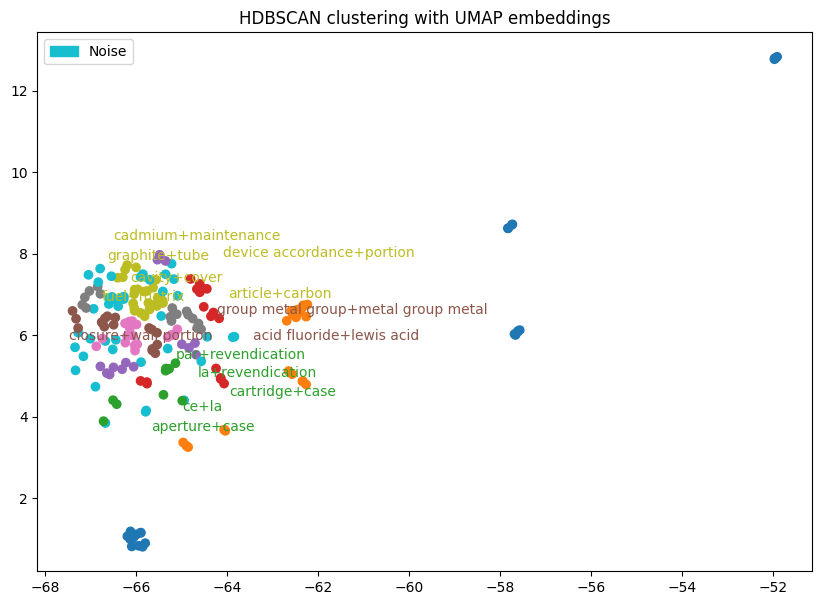

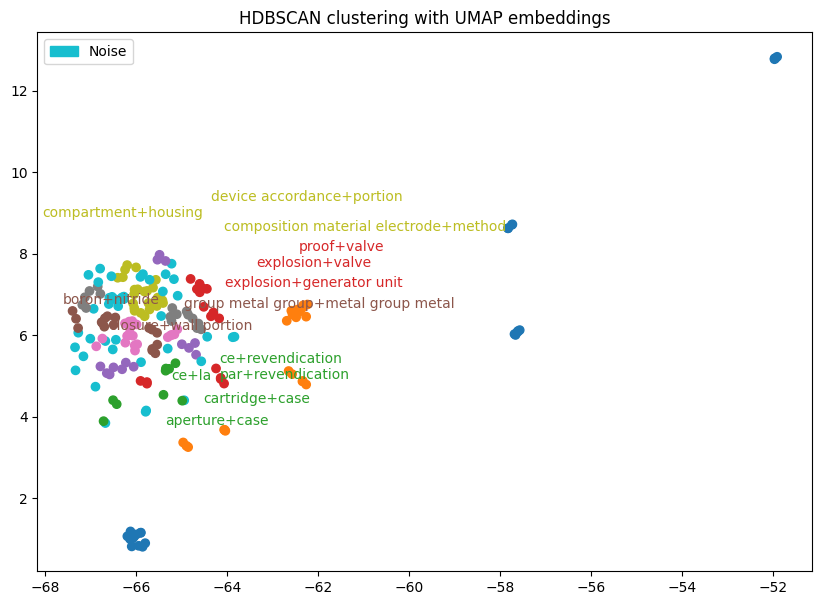

shape cluster_noise_control_dummy: (1159, 2625)
Shape of X: (1159, 2625)


  0%|          | 0/50 [00:00<?, ?it/s]

0 tentative features are now accepted: []
0 tentative features are now rejected: []
BorutaShap took 68.16591024398804 seconds


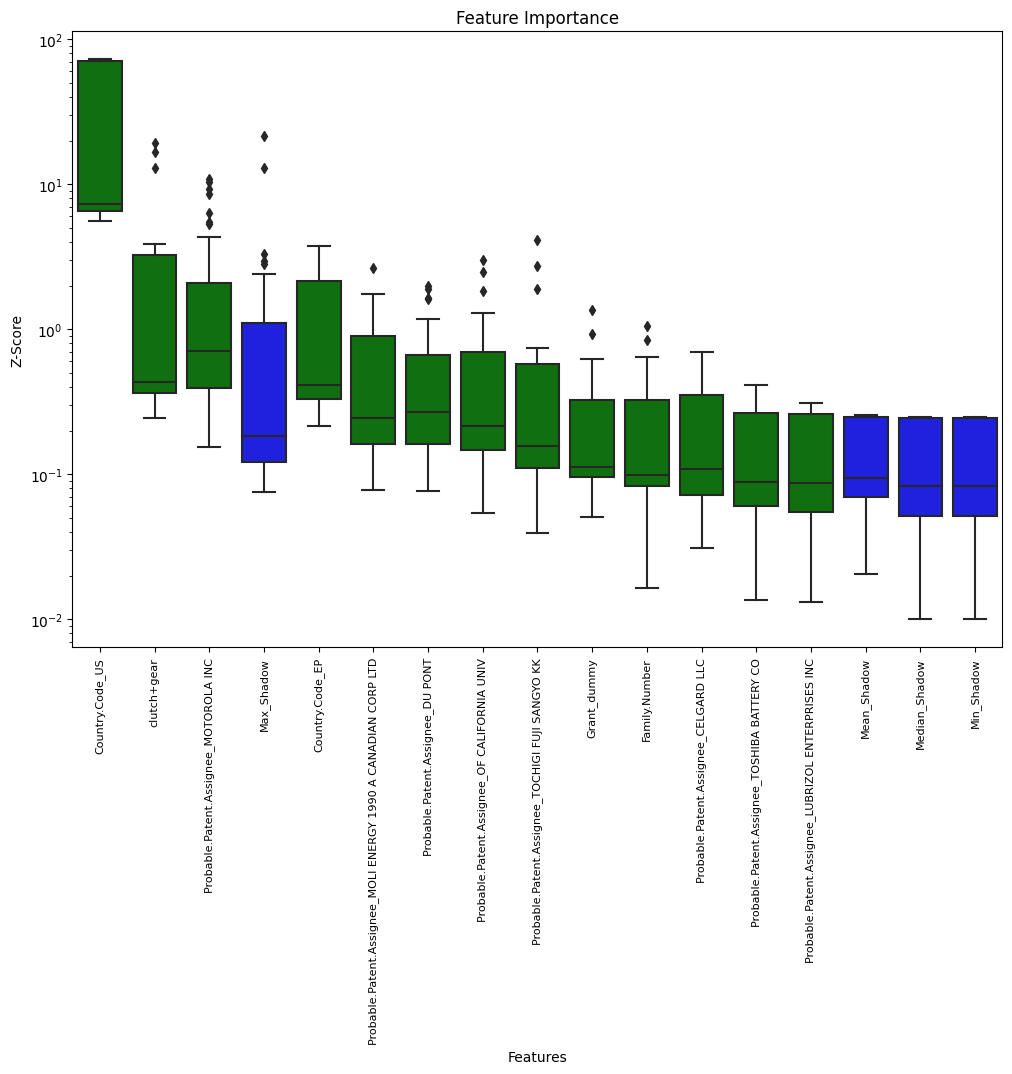

find_top_sentences took 0.13543438911437988 seconds
Maximum Tree Depth: 3


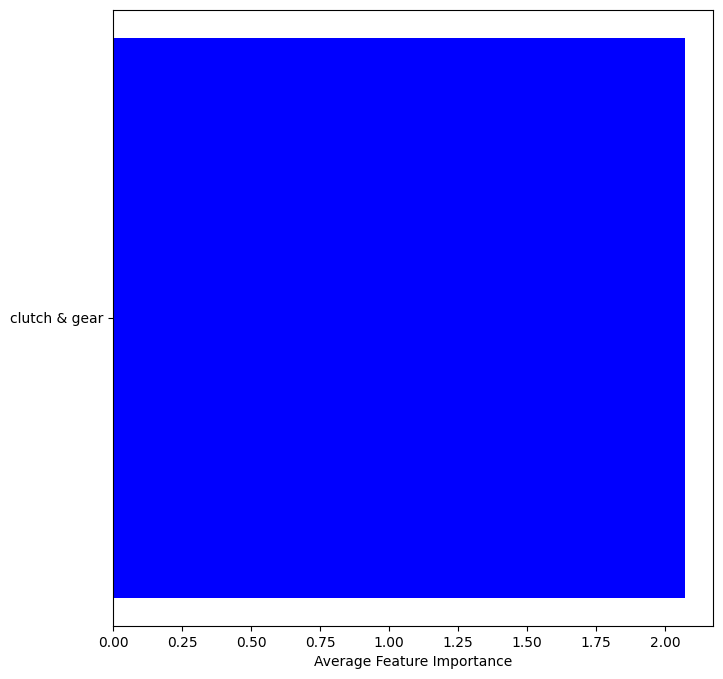

In [9]:
tree_depth=3
rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=tree_depth)
start=1920.0; stop=1990
print(f'Analyzing years {start} - {stop}...')
main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)
plot_word_pair_imps(start, stop, tree_depth)

Analyzing years 1920.0 - 1990...


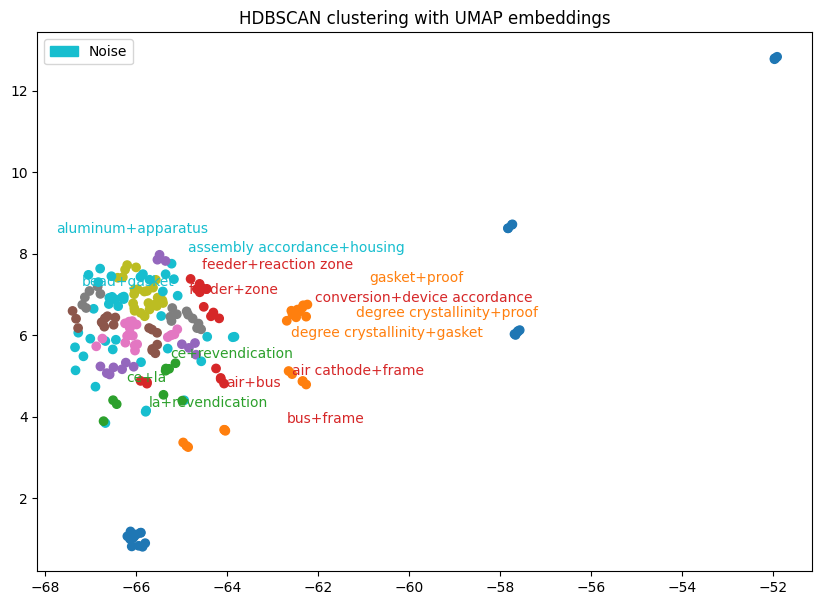

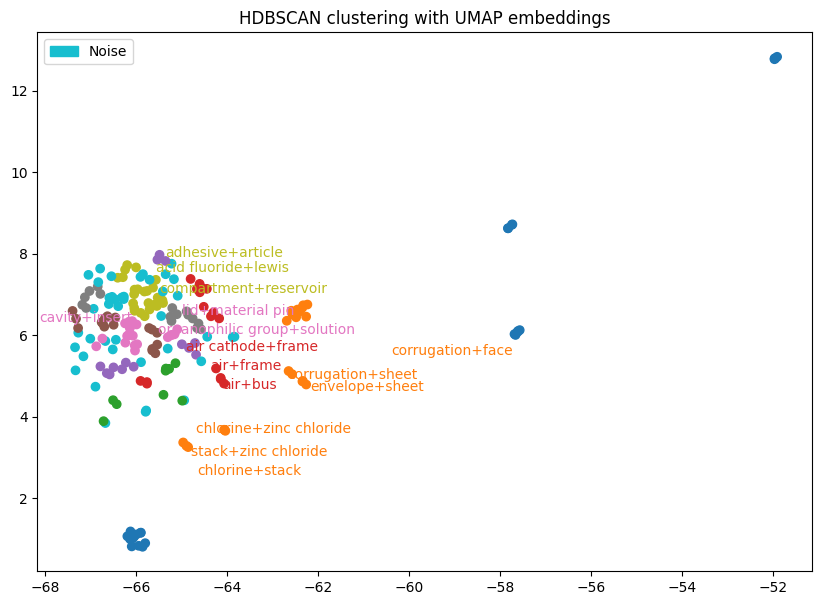

shape cluster_noise_control_dummy: (1159, 2625)
Shape of X: (1159, 2625)


  0%|          | 0/50 [00:00<?, ?it/s]

0 tentative features are now accepted: []
5 tentative features are now rejected: ['Probable.Patent.Assignee_TOSHIBA BATTERY CO' 'Country.Code_WO'
 'Probable.Patent.Assignee_CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE'
 'A' 'Probable.Patent.Assignee_ENERGY CONVERSION DEVICES INC']
BorutaShap took 79.21602535247803 seconds


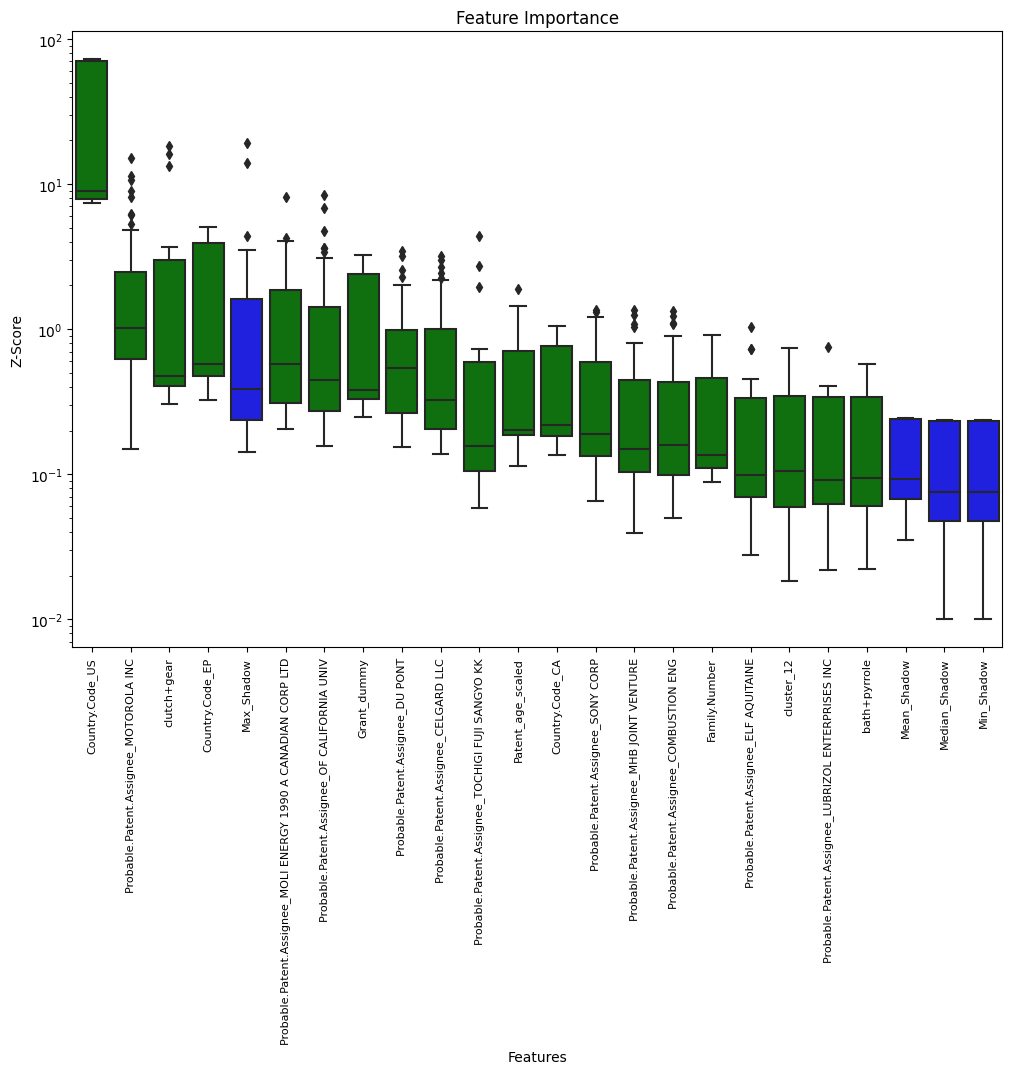

find_top_sentences took 0.260465145111084 seconds
Maximum Tree Depth: 7


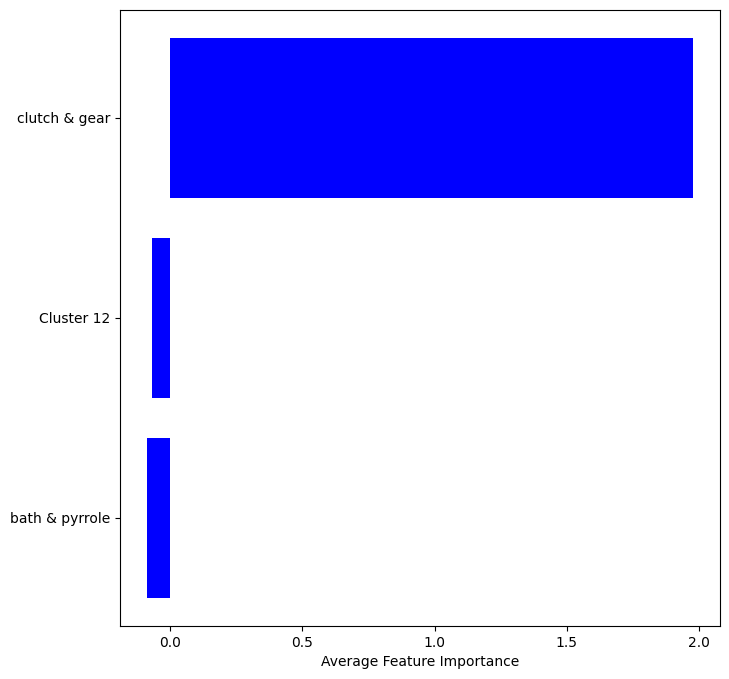

In [10]:
tree_depth=7
rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=tree_depth)
start=1920.0; stop=1990
print(f'Analyzing years {start} - {stop}...')
main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)
plot_word_pair_imps(start, stop, tree_depth)

Analyzing years 1991 - 2008...


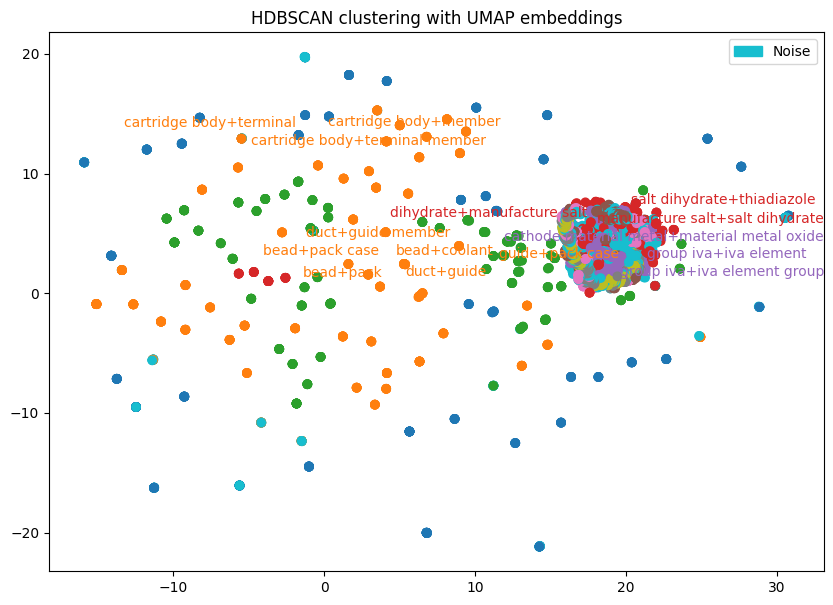

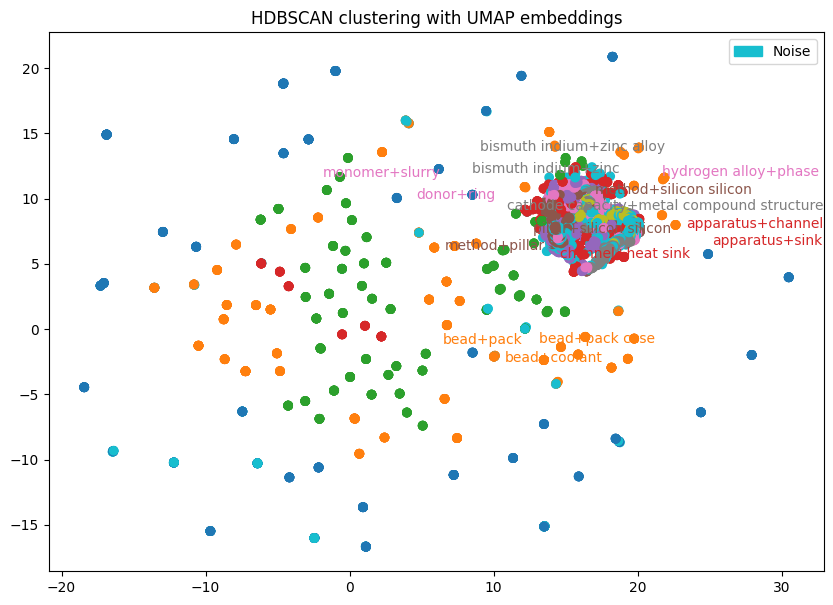

shape cluster_noise_control_dummy: (10938, 3722)
Shape of X: (10938, 3722)


  0%|          | 0/50 [00:00<?, ?it/s]

0 tentative features are now accepted: []
4 tentative features are now rejected: ['Probable.Patent.Assignee_POLYPLUS BATTERY CO'
 'Probable.Patent.Assignee_CANON INC'
 'Probable.Patent.Assignee_HYDRO QUEBEC'
 'Probable.Patent.Assignee_COVALENT ASSOCIATES INC']
BorutaShap took 524.5293140411377 seconds


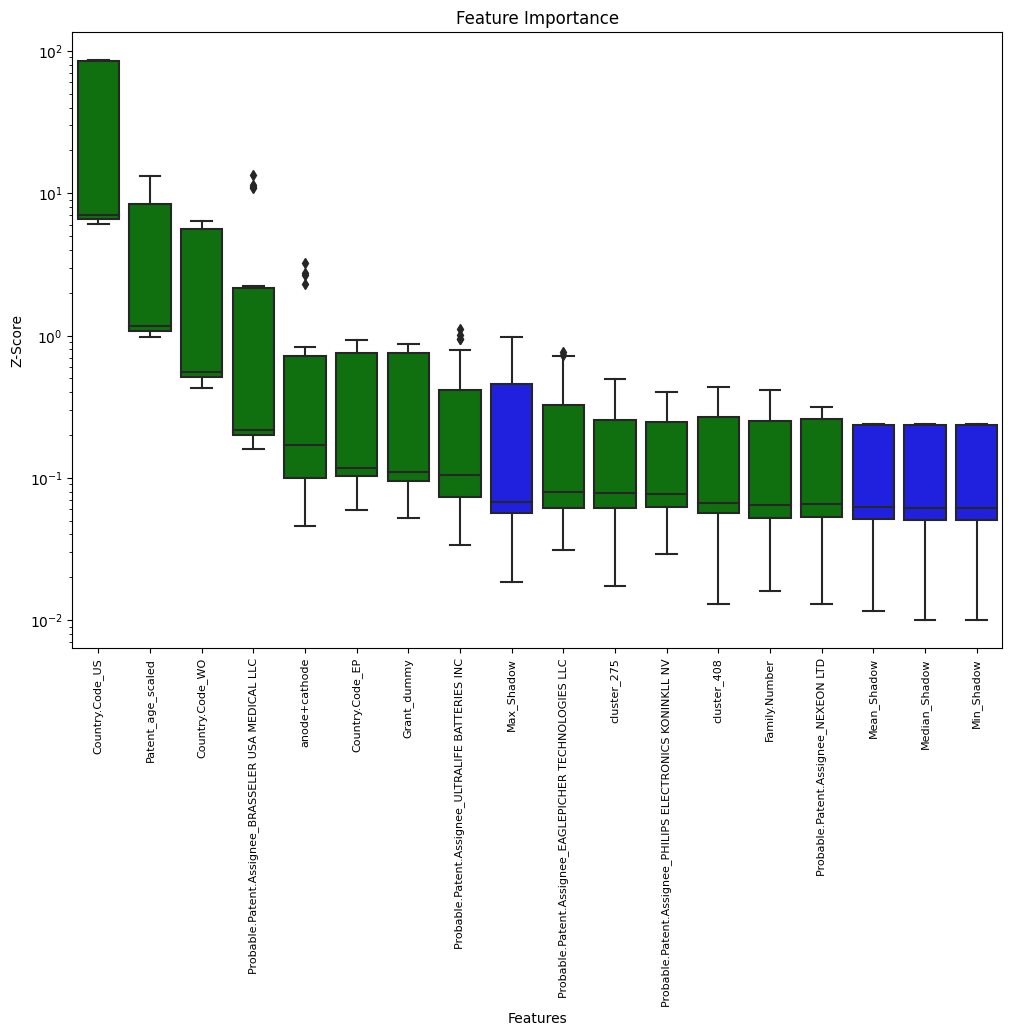

find_top_sentences took 0.08532333374023438 seconds
Maximum Tree Depth: 3


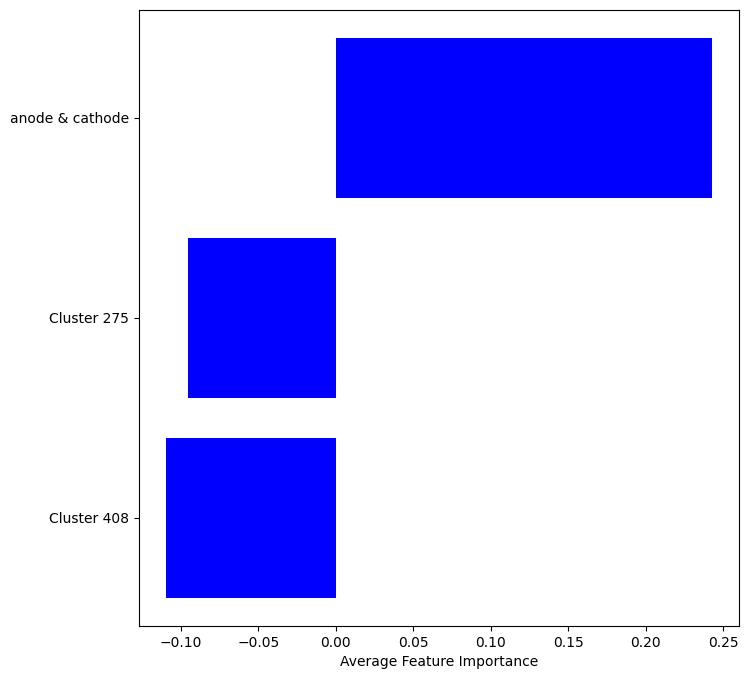

Analyzing years 1991 - 2008...


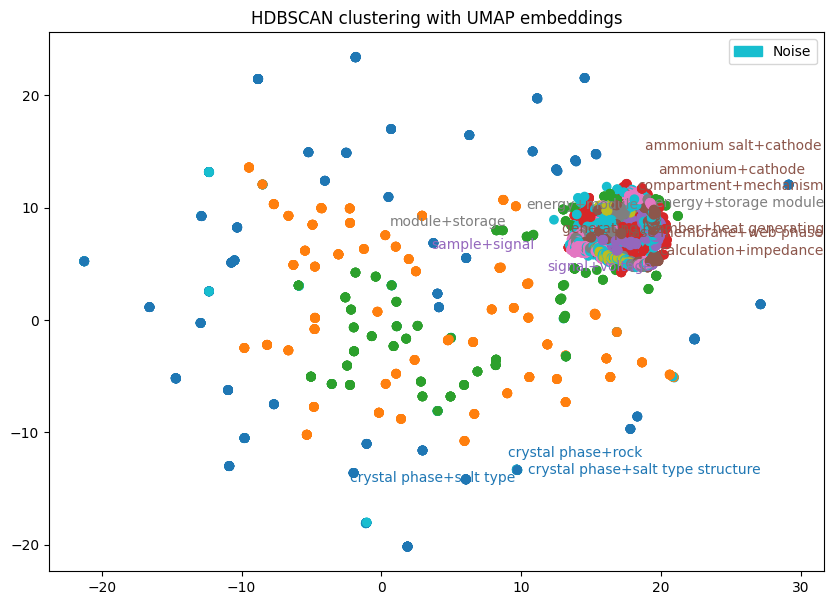

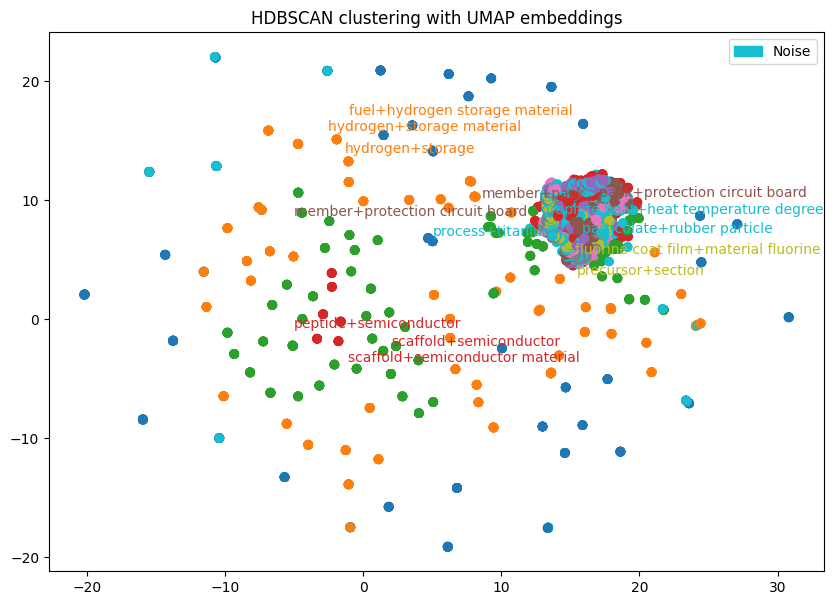

shape cluster_noise_control_dummy: (10938, 3723)
Shape of X: (10938, 3723)


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
tree_depth=3
rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=tree_depth)
start=1991; stop=2008
print(f'Analyzing years {start} - {stop}...')
main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)
plot_word_pair_imps(start, stop, tree_depth)

tree_depth=7
rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_depth=tree_depth)
start=1991; stop=2008
print(f'Analyzing years {start} - {stop}...')
main(df, time_periods=[(start, stop)], max_df=0.5, max_feat=None, tfidf_threshold_percentile=99, n_components=2, n_try=50)
plot_word_pair_imps(start, stop, tree_depth)